# Variational inference for Gaussian Mixture models

In this notebook, we implement the process of variational inference for Gaussian mixture models. 

The theory part summarize the result from Section 10.2. Note that derivation is not included in this notebook. 

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import time

%matplotlib inline
mpl.rc("savefig",dpi=100)

## 1. Theory

### 1.1 Model

Let 
* $N \in \mathbb{N}$ be the number of data points, and
* $D \in \mathbb{N}$ be the input dimension.

Then, 
a Gaussian mixture model with $K  \in \mathbb{N}$ components, with prior on parameters, for the $N$ data points  is defined by 

$$
\begin{eqnarray}
    & p(\pi) = {\rm Dir}(\pi | \alpha_0)\\
    & p(Z | \pi) = \prod_{n=0}^{N-1} \prod_{k=0}^{K-1} \pi_{k}^{z_{n,k}} \\
    & p\left(X \middle| Z, \mu, \Lambda, \pi \right) = 
    \prod_{n=0}^{N-1} \prod_{k=0}^{K-1} \mathcal{N}\left(x_n \middle| \mu_k , \Lambda_{k}^{-1} \right)^{z_{n,k}} \\
    & p(\Lambda) =  \prod_{k=0}^{K-1} \mathcal{W}\left(\Lambda_k \middle| W_0, \nu_0 \right)\\
    & p(\mu|\Lambda) = \prod_{k=0}^{K-1} \mathcal{N}\left(\mu_k \middle| m_0, (\beta_0 \Lambda_k)^{-1} \right)
\end{eqnarray}
$$

where 
* $X = (x_{n,k})_{ n \in \{ 0, 1, \dots, N-1 \} k \in \{ 0,1, \dots, K-1 \}  }, \ x_{n,k}\in \mathbb{R}^d$ is the matrix that stands for data points, 
* $Z = (z_{n,k})_{ n \in \{ 0, 1, \dots, N-1 \} k \in \{ 0,1, \dots, K-1 \}  }, \ z_{n,k}\in \{0,1 \}, \sum_{k=0}^{K-1}z_{n,k}=1$, is the matrix that stands for latent variables, 
* $\pi_k \geq 0, \sum_{k=0}^{K-1} \pi_k = 1$, 
* $\mathcal{N}\left(x \middle| \mu_k , \Lambda_{k}^{-1} \right)$ is the Gaussian probability density with mean $\mu_k \in \mathbb{R}^d$ and precision matrix $\Lambda_k$, 
* ${\rm Dir}(\pi | \alpha_0)$ is the probability density of the Dirichlet distribution, and 
* $\mathcal{W}\left(\Lambda_k \middle| W_0, \nu_0 \right)$ is the probability density of the Wishart distribution.

With these distributions, the whole joint distribution is defined by 

$$
\begin{align}
    p\left(X, Z, \pi, \mu, \Lambda \right)
    = p\left(X \middle| Z, \mu, \Lambda, \pi \right) 
    p(Z | \pi)
    p(\pi)
    p(\mu|\Lambda)
    p(\Lambda)
\end{align}
$$


### 1.2 Variational distribution

Our goal here is to approximate the posterior distribution $p(Z, \pi,\mu,\Lambda| X)$ by a variational distribution $q(Z, \pi, \mu, \Lambda)$. 

The result is 

$$
\begin{align}
    q(Z, \pi, \mu, \Lambda) = q(Z) q(\pi) \prod_{k=0}^{K-1} q(\mu_k, \Lambda_k), 
\end{align}
$$

where 

$$
\begin{align}
    &{}& q(Z) = \prod_{n=0}^{N-1} \prod_{k=0}^{K-1} r_{n,k}^{z_{n,k}} \\
    &{}& q(\pi) = {\rm Dir}(\pi|\alpha) \\
    &{}& q(\mu_k, \Lambda_k) = 
    \mathcal{N}\left(\mu_k \middle| m_k, (\beta_k \Lambda_k)^{-1}\right)
    \mathcal{W}\left( \Lambda_k \middle| W_k, \nu_k \right)
\end{align}
$$

with parameters defined by 


$$
\begin{align}
    \mbox{For $q(Z)$} & \\
    & r_{n,k} := \frac{\rho_{n,k}}{\sum_{j=1}^{K} \rho_{n,j}} \\
    & \rho_{n,k} := \frac{\tilde{\pi}_k \tilde{\Lambda}_{k}^{1/2}}{(2\pi)^{D/2}}
        \exp\left[ - \frac{D}{2\beta_k} - \frac{\nu_k}{2} (x_n - m_k)^T W_k (x_n - m_k) \right] \\
    & \tilde{\pi}_k := \exp \left[ \psi(\alpha_k) - \psi(\hat{\alpha}) \right] \\ 
    & \tilde{\Lambda}_k := \exp\left[ \sum_{i=0}^{D-1} \psi\left( \frac{\nu_k-i}{2} \right)  + D\log 2 + \log(\det W_k) \right] \\
    &\psi(a) := \frac{d}{da} \log \Gamma(a) \ \ (\mbox{digamma function}) \\
    & \hat{\alpha} := \sum_{k=1}^{K} \alpha_k \\
    \mbox{For $q(\pi, \Lambda, \mu)$} &{}& \\
    & \alpha_k := \alpha_0 + N_k \\
    & \beta_k := \beta_0 + N_k \\
    & \nu_k := \nu_0 + N_k \\
    & m_k := \frac{1}{\beta_k}(\beta_0 m_0 + N_k \bar{x}_k) \\
    & W_{k}^{-1} := W_{0}^{-1} + N_k S_k 
    + \frac{\beta_0 N_k}{\beta_0 + N_k}(\bar{x}_k - m_0)(\bar{x}_k - m_0)^T \\
    & N_k := \sum_{n=0}^{N-1} r_{n,k} \\
    & \bar{x}_k := \frac{1}{N_k} \sum_{n=0}^{N-1} r_{n,k} x_n \\
    & S_k := \frac{1}{N_k} \sum_{n=0}^{N-1} r_{n,k}(x_n - \bar{x}_k)(x_n - \bar{x}_k)^T \\
\end{align}
$$

Note that the above expression is not a closed form expression, because the distributions of $Z$ and $(\pi, \mu, \Lambda)$ depend on each other. 

The self-consistent solution can be obtained by iteration (Note: We do not discuss the convergence properties).

### 1.3 Algorithm

1. Fix hyperparameters $\alpha_0, \beta_0, \nu_0, m_0, W_0$
2. Initialize parameter $r_{n,k}$
3. Calculate $\alpha_k, \beta_k, \nu_k, m_k, W_k$ from $r_{n,k}$.
4. Calculate $r_{n,k}$ from $\alpha_k, \beta_k, \nu_k, m_k, W_k$
5. Repeat 2 and 3 until the parameters converge.

## 2. From math to code

### 2.1 Arrays

* X : (N,D) array stands for input data
* R : (N,K) array, where R[n,k] = $r_{n,k}$
* alpha : (K,) array, where alpha[k] = $\alpha_k$
* beta : (K,) array, where beta[k] = $\beta_k$
* nu : (K, ) array, where nu[k] = $\nu_k$
* M : (K,D) array, where M[k,i] = $m_{k,i}$
* W : (K,D,D) array, where W[k,i,j] = $(W_{k})_{i,j}$

### 2.2 Calculation 


In [404]:
# For calculating digamma function, 
# we use scipy.special.digamma 
# ( https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.digamma.html ).
from scipy.special import digamma
# Also, for calculating gamma function in the predictive distribution, 
# we use scipy.special gamma
from scipy.special import gamma

class Bayesian_gaussian_mixture_model:
    def __init__(self, D, K):
        self.K = K
        self.D = D
        
        # data
        self.X = None
        self.N = None
            
        # variables 
        self.R = None
        self.alpha = None
        self.beta = None
        self.nu = None
        self.M = None
        self.W = None
        
    # checking the size of the hyper parameters
    def size_is_correct(self,hparams):
        out = np.array([\
                        np.shape(hparams['alpha0']) == (),\
                        np.shape(hparams['beta0']) == (),\
                        np.shape(hparams['nu0']) == (),\
                        np.shape(hparams['m0']) == (self.D,),\
                        np.shape(hparams['W0']) == (self.D,self.D),\
                       ])
        return all(out)
    
    def set_hparams(self,hparams):
        # Hyper parameters
        if self.size_is_correct(hparams):
            self.alpha0 = hparams['alpha0']
            self.beta0 = hparams['beta0']
            self.nu0 = hparams['nu0']
            self.m0 = hparams['m0']
            self.W0 = hparams['W0']
        else:
            print("The size of hyperparameters is wrong.")

    def load_dat(self, Xdat):
        self.N = len(Xdat)
        if np.shape(Xdat) != (self.N,self.D):
            print("Error: Input dimension is inconsistent.")
        else:
            self.X = Xdat
    
    def init_params(self):
        self.alpha = (self.alpha0 + self.N/self.K)*np.ones(self.K)
        self.beta = (self.beta0 + self.N/self.K)*np.ones(self.K)
        self.nu = (self.nu0 + self.N/self.K)*np.ones(self.K)
        ind = np.random.randint(0, self.N, size=self.K)
        self.M = self.X[ind]
        self.W = np.tile(np.eye(self.D), (self.K,1,1))
        
    def get_params(self):
        params = {'alpha':self.alpha,\
                  'beta':self.beta,\
                  'nu':self.nu, \
                  'M':self.M, \
                  'W':self.W}
        return params
        

    # calculate r_{n,k} from \alpha_k, \beta_k, \nu_k, m_k, W_k        
    def calc_R(self, disp = False):
        # We set the following two temporal arrays.
        # * tpi : (K,) array, where tpi[k] = $\tilde{\pi}_k$
        # * tlam : (K,) array, where tlam[k] = $\tilde{\Lambda}_k$
        # * rho : (N,K) array, where rho[n,k] = $\rho_{n,k}$

        # calculating tpi is straightforward
        tpi = np.exp( digamma(self.alpha) - digamma(np.sum(self.alpha))   )
        
        # calculating tlam
        # numpy broadcasting is utilizes in calculating tmp, where tmp[k,i] = nu_k - i
        tmp = np.reshape(self.nu,(self.K,1)) - np.reshape(np.arange(0,self.D,1),(1,self.D))
        tlam = np.exp( np.sum(digamma(tmp/2),axis=1)  + self.D*np.log(2) + np.log(np.linalg.det(self.W)) )
        
        # calculating rho
        # first, we calculate a (N, K, D) array "diff", where diff[n,k,i] = (x_n - m_k)_{i}
        diff = np.reshape(self.X, (len(self.X),1,self.D) ) - np.reshape(self.M, (1, self.K, self.D) )
        # then, we calculate a (N,K) array "tmp2", where tmp2[n,k] = D/\beta_k  + \nu_k (x_n-m_k)^T W_k (x_n-m_k)
        tmp2 = self.D/self.beta + self.nu*np.einsum("nkj,nkj->nk",np.einsum("nki,kij->nkj",diff,self.W),diff)
        # Combining these results, we can get rho, where 2\pi factor is omitted, because it does not affect the result
        # However, note that, because rho contains exponential factor, it often happens that \sum_{j=0}^{K-1}\rho_{j,k} = 0
        tmp3 = tmp2 - np.reshape(np.min(tmp2, axis=1), (self.N,1))
        rho = tpi*np.sqrt(tlam)*np.exp( -0.5*tmp3 )
        # and r
        self.R = rho/np.reshape(np.sum(rho,axis=1),(self.N,1))
        
        if disp:
            print(f"Nk : {np.sum(self.R,axis=0)}")
        
    # calculate \alpha_k, \beta_k, \nu_k, m_k, W_k  from r_{n,k} 
    def calc_dist(self, disp=False):
        # N_k, (K,) array
        Nks = np.sum(self.R, axis=0)
        # barx: (K,D) array, barx[k,i] = (\bar{x}_k)_i
        barx = (self.R).T @ self.X / np.reshape(Nks,(self.K,1))
        # S : (K, D, D) array S[k,i,j]  = (S_k)_{i,j}
        # diff : (N,K,D) array diff[n,k,i] = x_{n,i} - \bar{x}_{k,i}
        diff = np.reshape(self.X, (self.N,1,self.D) ) - np.reshape(barx, (1, self.K, self.D) )
        S = np.einsum("nki,nkj->kij", np.einsum("nk,nki->nki",self.R, diff), diff)/np.reshape(Nks,(self.K,1,1))
        
        self.alpha = self.alpha0 + Nks
        self.beta = self.beta0 + Nks
        self.nu = self.nu0 + Nks
        self.M = (self.m0 * self.beta0 + barx*np.reshape(Nks, (self.K, 1)))/np.reshape(self.beta,(self.K,1))
        
        # Calculating W
        diff2 = barx - self.m0
        Winv = np.reshape(np.linalg.inv( self.W0 ), (1,self.D,self.D)) + S*np.reshape(Nks,(self.K,1,1)) + \
            np.reshape( self.beta0*Nks/(self.beta0 + Nks), (self.K,1,1))*np.einsum("ki,kj->kij",diff2,diff2) 
        self.W = np.linalg.inv(Winv)
        
        if disp:
            print(f"alpha : {self.alpha}")
            print(f"beta : {self.beta}")
            print(f"nu : {self.nu}")
            print(f"mu : {self.M}")
            print(f"W : {self.W}")

        
    def fit(self,Xdat, max_iter, tol, disp_message):
        self.load_dat(Xdat)
        self.init_params()
        
        for i in range(max_iter):
            alpha_tmp = self.alpha
            beta_tmp = self.beta
            nu_tmp = self.nu
            M_tmp = self.M
            W_tmp = self.W
            
            self.calc_R()
            self.calc_dist()
            err = np.array([np.linalg.norm(self.alpha - alpha_tmp), \
                            np.linalg.norm(self.beta - beta_tmp), \
                            np.linalg.norm(self.nu - nu_tmp), \
                            np.linalg.norm(self.M - M_tmp), \
                            np.linalg.norm(self.W - W_tmp)])
            if all(err < tol):
                break
        if disp_message:
            print(f"n_iter : {i}")
            print(f"Change in parameters : {err}")
        
    # multivariate student-t distribution
    def multi_student_t(self, x, mu, L, nu, D):
        diff = x - mu
        d2 = np.diag(diff @ L @ (diff.T))
        coeff = gamma( (nu + D)/2 )/gamma(nu/2) * (np.linalg.det(L)**0.5) / ((nu*np.pi)**(D/2))
        return coeff/((1 + d2/nu)**(0.5*nu + 0.5*D))
        
    def predict(self, Xtest):
        L = np.reshape( (self.nu + 1 - self.D)/(1 + self.beta), (self.K, 1,1) ) * self.W
        tmp = np.zeros((len(Xtest), self.K))
        for k in range(K):
            tmp[:,k] = self.multi_student_t(Xtest, self.M[k], L[k], self.nu[k] + 1 - self.D, self.D)
        return (tmp @ self.alpha) / np.sum(self.alpha)
        

## 4 Experiment

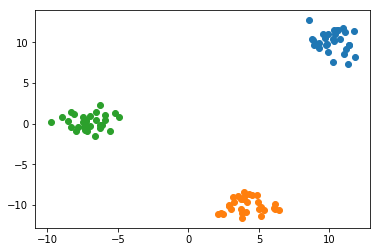

In [412]:
K = 3 # the number of components
NK = 30  # the number of data points for each component
Xdat = np.zeros((NK*K,2))
mus = np.array([[10,10],[4,-10],[-7,0]])

for k in range(K):
    Xdat[NK*k:NK*k+NK] = np.random.multivariate_normal(mean=mus[k],cov=np.eye(2),size=NK)

# mesh, which will be used for plotting later
xx = np.linspace(np.min(Xdat[:,0])-5,np.max(Xdat[:,0])+5,101)
yy = np.linspace(np.min(Xdat[:,1])-5,np.max(Xdat[:,1])+5,100)
Xtest = np.array([[x,y] for x in xx  for y in yy])
xxx,yyy = np.meshgrid(xx,yy)

for k in range(K):
    plt.plot(Xdat[NK*k:NK*k+NK,0],Xdat[NK*k:NK*k+NK,1],'o')
plt.show()

In [424]:
gmm = Bayesian_gaussian_mixture_model(D=2,K=3)
hparams = {"alpha0":1.0,\
          "beta0":0.05,\
          "nu0":3.0,\
          "m0":np.zeros(2),\
          "W0":np.eye(2)
         }
gmm.set_hparams(hparams)
gmm.fit(Xdat, max_iter=300, tol=1e-4, disp_message=True)
print(f"alpha : {gmm.alpha}")
print(f"beta : {gmm.beta}")
print(f"nu : {gmm.nu}")
print(f"mu : {gmm.M}")
print(f"W : {gmm.W}")
print(f"Nk : {np.sum(gmm.R,axis=0)}")

n_iter : 1
Change in parameters : [ 0.  0.  0.  0.  0.]
alpha : [ 31.  31.  31.]
beta : [ 30.05  30.05  30.05]
nu : [ 33.  33.  33.]
mu : [[ -7.07969174   0.22411972]
 [  4.14349959 -10.00575227]
 [ 10.19812462  10.11871311]]
W : [[[ 0.0257489  -0.00285898]
  [-0.00285898  0.04345555]]

 [[ 0.0238407   0.00098944]
  [ 0.00098944  0.03367712]]

 [[ 0.03183763  0.00128257]
  [ 0.00128257  0.01927514]]]
Nk : [ 30.  30.  30.]


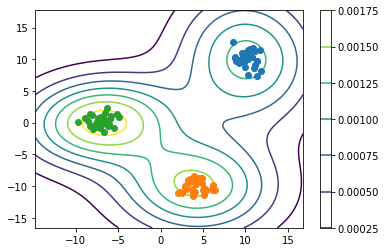

In [425]:
prob = gmm.predict(Xtest)
prob_2D = np.reshape(prob,(len(xx),len(yy))).T

plt.contour(xxx,yyy,prob_2D)
#plt.pcolormesh(xxx,yyy,prob_2D,cmap='gray')
plt.colorbar()

for k in range(K):
    plt.plot(Xdat[NK*k:NK*k+NK,0],Xdat[NK*k:NK*k+NK,1],'o')

It seems that the result significantly depends on the choice of hyperparameters. 

n_iter : 7
Change in parameters : [  4.27803378e-14   4.27803378e-14   4.01943669e-14   1.22447395e-14
   9.73591239e-16]
alpha : [ 31.  31.  31.]
beta : [ 30.5  30.5  30.5]
nu : [ 33.  33.  33.]
mu : [[ -6.97523727   0.22081303]
 [  4.08236599  -9.85812642]
 [ 10.04766049   9.96942062]]
W : [[[ 0.01634153 -0.00131727]
  [-0.00131727  0.04320289]]

 [[ 0.02251389  0.0059583 ]
  [ 0.0059583   0.01506903]]

 [[ 0.01722945 -0.00772124]
  [-0.00772124  0.0137256 ]]]
Nk : [ 30.  30.  30.]


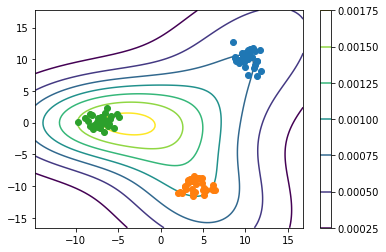

In [420]:
gmm = Bayesian_gaussian_mixture_model(D=2,K=3)
hparams = {"alpha0":1.0,\
          "beta0":0.5,\
          "nu0":3.0,\
          "m0":np.zeros(2),\
          "W0":np.eye(2)
         }
gmm.set_hparams(hparams)
gmm.fit(Xdat, max_iter=300, tol=1e-4, disp_message=True)
print(f"alpha : {gmm.alpha}")
print(f"beta : {gmm.beta}")
print(f"nu : {gmm.nu}")
print(f"mu : {gmm.M}")
print(f"W : {gmm.W}")
print(f"Nk : {np.sum(gmm.R,axis=0)}")

prob = gmm.predict(Xtest)
prob_2D = np.reshape(prob,(len(xx),len(yy))).T

plt.contour(xxx,yyy,prob_2D)
#plt.pcolormesh(xxx,yyy,prob_2D,cmap='gray')
plt.colorbar()

for k in range(K):
    plt.plot(Xdat[NK*k:NK*k+NK,0],Xdat[NK*k:NK*k+NK,1],'o')